In [1]:
import numpy as np
from numba import cuda
import cupy as cp

Используемый источник: https://numba.readthedocs.io/en/stable/cuda/examples.html#vector-addition

In [2]:
def CPU_VectorSum(A, B):
    if len(A) != len(B):
        raise Exception('Can\'t summate vectors with provided dimensions')
    C_cpu = np.zeros(len(A))
    for i in range(len(A)):
      C_cpu[i] += A[i] + B[i]
    return C_cpu

In [3]:
@cuda.jit()
def VectorSum_in_GPU(A, B, C):
# like threadIdx.x + (blockIdx.x * blockDim.x)
    tid = cuda.grid(1)
    size = len(C)

    if tid < size:
        C[tid] = A[tid] + B[tid]

In [4]:
def GPU_VectorSum(A, B):
    C_сpu = np.zeros(len(A))

    #Передаем данные на устройство (GPU)
    A_gpu = cuda.to_device(A)
    B_gpu = cuda.to_device(B)
    C_gpu = cuda.to_device(C_сpu)

    VectorSum_in_GPU.forall(len(A))(A_gpu, B_gpu, C_gpu)

    #Передаем данные с устройства на хост (на CPU)
    C_сpu = C_gpu.copy_to_host()
    return C_сpu

In [33]:
#[1000, 5000, 10000, 50000, 100000, 500000, 1000000]
SIZE = [1000000]

A = np.random.uniform(0, 1, size=SIZE)
B = np.random.uniform(0, 1, size=SIZE)

In [34]:
#Время сложения на CPU
%%time
CPU_VectorSum(A, B)

CPU times: user 482 ms, sys: 12.3 ms, total: 495 ms
Wall time: 495 ms


array([1.02331725, 0.79726139, 1.3272498 , ..., 0.66135695, 1.03177295,
       0.86013159])

In [35]:
#Время сложения на GPU
%%time
GPU_VectorSum(A, B)

CPU times: user 10.8 ms, sys: 7.02 ms, total: 17.8 ms
Wall time: 19.6 ms


array([1.02331725, 0.79726139, 1.3272498 , ..., 0.66135695, 1.03177295,
       0.86013159])

In [36]:
#Проверка результатов сложения на CPU и GPU
np.allclose(CPU_VectorSum(A, B), GPU_VectorSum(A, B))

True

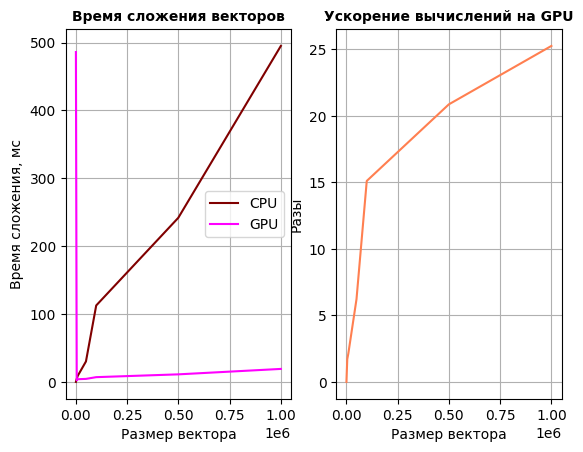

In [40]:
from matplotlib import pyplot as plt
size = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
CPU_time = [0.460, 4.92, 9.44, 30.6, 113, 242, 495]
GPU_time = [486, 2.88, 4.46, 4.92, 7.48, 11.6, 19.6]

acceleration = [cpu / gpu for cpu, gpu in zip(CPU_time, GPU_time)]

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(size, CPU_time, label='CPU', color='maroon')
axes[0].plot(size, GPU_time, label='GPU', color='fuchsia')
axes[0].grid(True)
axes[0].legend()
axes[0].set_xlabel("Размер вектора")
axes[0].set_ylabel("Время сложения, мс")
axes[0].set_title('Время сложения векторов', font = {'weight':'bold', 'size': 10})

axes[1].plot(size, acceleration, color='coral')
axes[1].grid(True)
axes[1].set_xlabel("Размер вектора")
axes[1].set_ylabel("Разы")
axes[1].set_title('Ускорение вычислений на GPU', font = {'weight':'bold', 'size': 10})

plt.show()